Timer para medir cuanto tiempo tarda cada parte del proceso

In [2]:
from timer import Timer
timer = Timer()

Definiciones de nombres de archivos de entrada y salida

In [46]:
T_FILE = "../Mediciones/tiempos.bin"
O_FILE = "../Mediciones/sic_phi.bin"
T1_OUT_FILE = "../Mediciones/t1.bin"

Lectura de datos

In [4]:
from read_times import read_times

In [19]:
timer.start()
t1, t2, t3, t4 = read_times(T_FILE)
timer.end("Finished reading data ({:.3f}s)")

Finished reading data (0.013s)


In [17]:
t1[0]

1543858735933270.0

Problema: t1 (cliente) y t2 (servidor) están MUY ALEJADOS (no era así con los datos originales, estaban a menos de 1 segundo) -> LO ARREGLO A MANO

In [23]:
import numpy as np

In [28]:
p = np.argmax(np.abs(t2-t1))

In [32]:
np.mean(np.abs(t2-t1))

17369864679431.955

In [29]:
t1[p]

1543956409292411.0

In [30]:
t2[p]

1526586542774990.0

In [31]:
t2[p] - t1[p]

-17369866517421.0

Now, we can estimate the $\Phi$ values using that $\Phi = (t_1-t_2-t_3+t_4)/2$

In [20]:
from estimate_phi import phi_estimation

timer.start()
phi_est = phi_estimation(t1, t2, t3, t4)
timer.end("Finished Phi estimation ({:.3f}s)")

Finished Phi estimation (0.012s)


In [33]:
phi_est = phi_est % 1000000

And plot the results

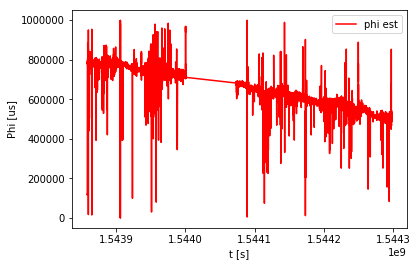

In [34]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(t1/1e6,phi_est,c='r')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi est',''));

In [70]:
np.max(np.diff(t1))

1499764.0

In [63]:
np.mean(np.diff(t1))

1017241.3382438588

Para completar los segundos que se saltea y los cambios no sean tan bruscos, interpolamos:

In [35]:
from estimate_phi import interpolate_missing_values

t1, phi_est = interpolate_missing_values(t1, phi_est)

In order to avoid the peaks in the figure, we can smooth the data replacing each point with the median of a window of 600 points

In [36]:
from median_calculator import median_window
import numpy as np


timer.start()
phi_med_600 = median_window(phi_est, 600)
phi_med_600 = np.array(phi_med_600)
t1 = t1[:len(phi_med_600)]
timer.end("Finished Phi median 600 ({:.3f}s)")

Finished Phi median 600 (6.275s)


In [54]:
np.argmax(phi_med_600 < 500000)

49176

In [57]:
phi_med_600[49176]
phi_med_600[49177]

499405.5487804878

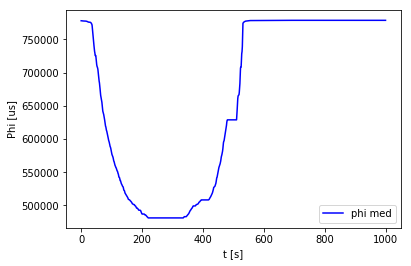

In [58]:
start = 49000
end = start + 1000
plt.plot(phi_med_600[start:end],c='b')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med',''));

And now we smooth again the data by using a linear regression

In [38]:
phi_med_600 = phi_med_600[:len(phi_med_600)//60*60]
t1 = t1[:len(phi_med_600)]
t1.tofile(T1_OUT_FILE)

In [39]:
from estimate_phi import linear_reg
timer.start()
f_lin, k_lin = linear_reg(t1, phi_med_600, 60)
phi_lin = np.zeros(len(t1))

for i in range(len(t1) // 60):
    phi_lin[i * 60:(i + 1) * 60] = t1[i * 60:(i + 1) * 60] * f_lin[i] + k_lin[i]
timer.end("Finished Phi lin reg 60 ({:.3f}s)")

Finished Phi lin reg 60 (3.997s)


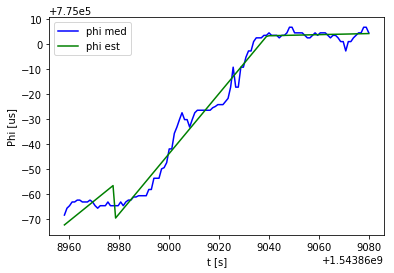

In [40]:
start = 10000
end = start + 120
plt.plot(t1[start:end]/1e6,phi_med_600[start:end],c='b');
plt.plot(t1[start:end]/1e6,phi_lin[start:end],c='g')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med', 'phi est'));

Now we apply an ARMA filter

In [41]:
from estimate_phi import arma_filter

timer.start()
alpha = 0.15
f, k = arma_filter(f_lin, k_lin, alpha)
phi_arma = np.zeros(len(t1))
for i in range(len(t1) // 60):
    phi_arma[i * 60:(i + 1) * 60] = t1[i * 60:(i + 1) * 60] * f[i] + k[i]
timer.end("Finished Phi ARMA ({:.3f}s)")

Finished Phi ARMA (0.102s)


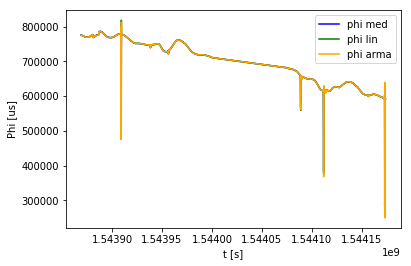

In [49]:
start = 10000
end = start + 300000
plt.plot(t1[start:end]/1e6,phi_med_600[start:end],c='b')
plt.plot(t1[start:end]/1e6,phi_lin[start:end],c='g')
plt.plot(t1[start:end]/1e6,phi_arma[start:end],c='orange')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med','phi lin', 'phi arma'));

In [59]:
np.max(np.diff(t1))

1499764.0

In [47]:
phi_arma.tofile(O_FILE)